## Replication of Results in Dr. Walch's Paper:
    # sleep stage prediction with raw acceleration and photoplethysmography heart rate data derived from a consumer wearable device
    # https://academic.oup.com/sleep/article/42/12/zsz180/5549536
    
    # an ML-based approach (not ODE-based)
    
    # Works Cited:
    
    Walch, O. (2019). Motion and heart rate from a wrist-worn wearable and labeled sleep from polysomnography (version 1.0.0). PhysioNet. https://doi.org/10.13026/hmhs-py35.
    
    Olivia Walch, Yitong Huang, Daniel Forger, Cathy Goldstein, Sleep stage prediction with raw acceleration and photoplethysmography heart rate data derived from a consumer wearable device, Sleep, Volume 42, Issue 12, December 2019, zsz180, https://doi.org/10.1093/sleep/zsz180
    
    Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.
    
    [Citation for scikit-learn & possibly other packages]

In [60]:
import numpy as np
import pandas as pd
import sklearn as skln
import matplotlib.pyplot as plt
from scipy import stats
from scipy import interpolate
from scipy import signal
from scipy import fft,ifft
from scipy.optimize import curve_fit
from tqdm import tqdm
import multiprocessing
import io,sys,os
from pathlib import Path

In [3]:
import utils as ul
import feature as feat
import load

In [4]:
nparams = 3
nfeat = 5

In [5]:
# PATHS:
star = '*'
stardot = '*.'
filetype = '.txt'
path_root = "../"
path_data = path_root+'data/'
path_fold = ul.join([path_data],['labels/','heart_rate/','motion/','steps/'])
path_filename = ['_labeled_sleep','_heartrate','_acceleration','_steps']
path_file = ul.join(path_filename,[filetype])
path_out = path_root+"out/"
#
path_idfile = path_out+"idlist.txt"

In [6]:
## INPUT DATA
ids = load.configure(path_idfile)

# load



In [7]:
path_file

['_labeled_sleep.txt', '_heartrate.txt', '_acceleration.txt', '_steps.txt']

In [8]:
nPatients = 2#42
ids=ids[0:nPatients]

In [9]:
path_fold[1]+str(ids[0])+path_file[1]

'../data/heart_rate/1066528_heartrate.txt'

In [10]:
data = np.zeros(shape=(nparams+1,nPatients),dtype=object)
# data[datatype][patientID]
with multiprocessing.Pool(processes=7) as pool:
        i=0
        pf = path_fold[i]
        pl = path_file[i]
        data[i] = np.array(list(tqdm(pool.starmap(load.dataloadS,ul.tuplejoin([pf],ids,[pl])))))
        i=1
        pf = path_fold[i]
        pl = path_file[i]
        data[i] = np.array(list(tqdm(pool.starmap(load.dataloadC,ul.tuplejoin([pf],ids,[pl])))))
        i=2
        pf = path_fold[i]
        pl = path_file[i]
        data[i] = np.array(list(tqdm(pool.starmap(load.dataloadS,ul.tuplejoin([pf],ids,[pl])))))
        i=3
        pf = path_fold[i]
        pl = path_file[i]
        data[i] = np.array(list(tqdm(pool.starmap(load.dataloadC,ul.tuplejoin([pf],ids,[pl])))))

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]


In [11]:
# making into arrays
# note PSG minimal duration from timeMIN to timeMAX with stamp every 30 seconds
timeMAX = min(np.array([max(data[0,i][:,0]) for i in range(nPatients)]))
timeMIN = 0
timeMAX

28530.0

In [33]:
#function
def arrayD(idq):
    tp = [0,0,1,2,2,2]
    tq = [0,1,1,1,2,3]
    sdata = np.zeros(shape=(nfeat+1,N))
    for u in range(nfeat+1):
        f = interpolate.interp1d(data[tp[u],idq][:,0],data[tp[u],idq][:,tq[u]])
        sdata[u,:] = f(x)
    return sdata

In [67]:
idq = 1 #patient id
# 50 ms / 20 FPS interpolated data
T = 0.05
N = int(timeMAX+1)*20
sleep = np.zeros(shape=(nPatients,(nfeat+1),N))
x = np.linspace(0,timeMAX,num=N,endpoint=True)
sleep = np.array([arrayD(idq) for idq in tqdm(range(nPatients))])

100%|████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.31it/s]


In [68]:
# [patient id, datatype, timestamp]
sleep[:,0]

array([[0.00000000e+00, 4.99983351e-02, 9.99966703e-02, ...,
        2.85299000e+04, 2.85299500e+04, 2.85300000e+04],
       [0.00000000e+00, 4.99983351e-02, 9.99966703e-02, ...,
        2.85299000e+04, 2.85299500e+04, 2.85300000e+04]])

In [69]:
# convert xyz accel into r,theta,phi
r = np.sqrt(np.power(sleep[:,3],2)+np.power(sleep[:,4],2)+np.power(sleep[:,5],2))
phi = np.arctan(sleep[:,4]/sleep[:,3])
theta = np.arccos(sleep[:,5]/r)
sleep[:,3]=r
sleep[:,4]=phi
sleep[:,5]=theta

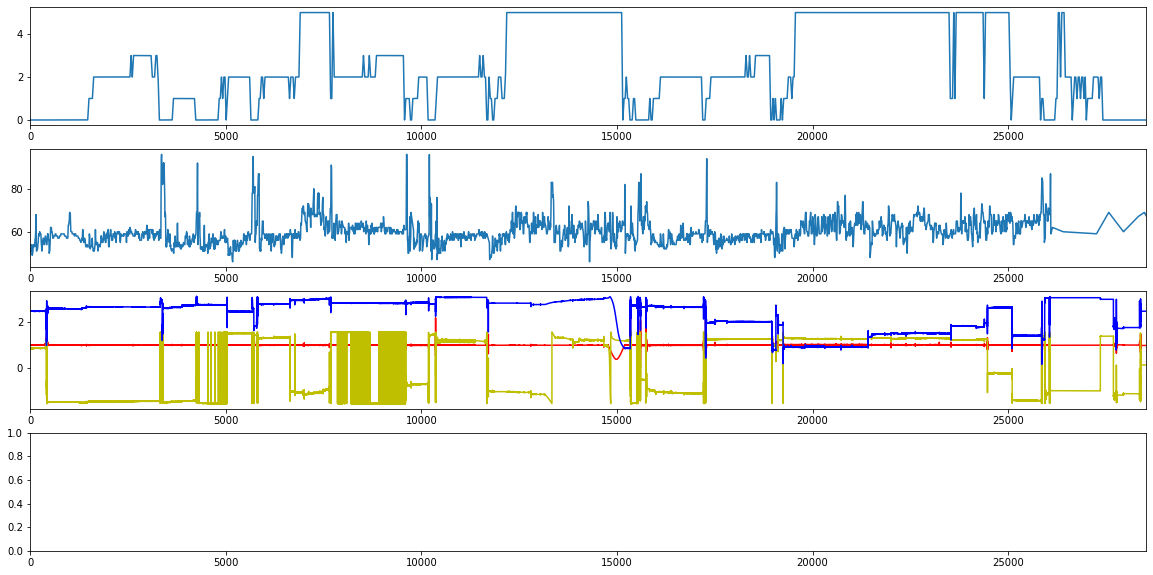

In [46]:
fig,axs = plt.subplots(4,figsize=(20,10))
for ax in axs:
    ax.set_xlim([timeMIN,timeMAX])
i = 0
for ide in range(1):
    sp = sleep[ide]
    axs[0].plot(sp[0],sp[1])
    axs[1].plot(sp[0],sp[2])
    axs[2].plot(sp[0],sp[3],c='r')
    axs[2].plot(sp[0],sp[4],c='y')
    axs[2].plot(sp[0],sp[5],c='b')

100%|████████████████████████████████████████████████████████████████████████████████████| 237/237 [00:03<00:00, 67.81it/s]
<ipython-input-188-ce78c587a43e>:20: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(cvl))


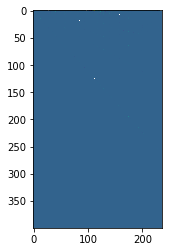

In [188]:
x = sleep[0,0]
y = sleep[0,2]

winTime = 120 #in seconds
wndX = int(winTime/T)
nPoints =  400
nStep = int(len(x)/wndX)

spectrumF = 1/np.linspace((1),(24*3600),num=nPoints,endpoint=False)
cvl = np.zeros(shape=(nPoints,nStep))

for j in tqdm(range(nStep)):
    x_set = x[j*wndX:((j+1)*wndX)-1]
    y_set = y[j*wndX:((j+1)*wndX)-1]
    for i in (range(nPoints)):
        f = spectrumF[i]
        sine = np.sin(2 * np.pi * f * x_set)
        sine = sine/np.sum(sine)
        cvl[i,j] = np.sum(np.convolve(sine, y_set, mode='valid'))/np.sum(y_set)
plt.imshow(np.log(cvl))
plt.show()

<ipython-input-212-94003da707a6>:1: RuntimeWarning: invalid value encountered in log
  plt.plot((N/nStep)*np.array(range(nStep)),1/(3600*np.exp(np.mean(np.log(cvl),axis=0))))


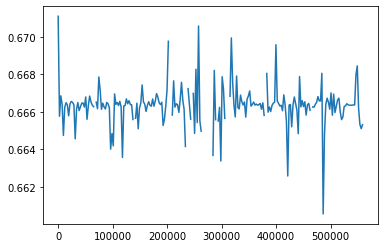

In [212]:
plt.plot((N/nStep)*np.array(range(nStep)),1/(3600*np.exp(np.mean(np.log(cvl),axis=0))))

<ipython-input-131-7dfb56ef9654>:6: RuntimeWarning: divide by zero encountered in true_divide
  xt = 1/(xf*3600)


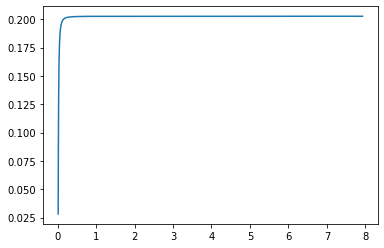

In [131]:
st=1000
nft = 1000
window = N
yf =fft.fft(sleep[1,2,st:st+nft],n=window,norm="ortho")
xf =fft.fftfreq(window, T)[:nft//2]
xt = 1/(xf*3600)
plt.plot(xt,2.0/nft * np.abs(yf[0:nft//2]))

In [26]:
# heartrate
df=pd.DataFrame(data[1][1])
df

,0,1
0,-573802.82896,84.0
1,-573385.82896,77.0
2,-573320.82902,75.0
3,-572814.45419,94.0
4,-572673.45401,105.0
...,...,...
6962,29287.76864,93.0
6963,29292.76864,93.0
6964,29298.76867,93.0
6965,29303.76867,92.0


In [ ]:
# heartrate during sleep